In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../definitions')
import def_model as mod_def
from sklearn.multioutput import MultiOutputRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, TimeSeriesSplit,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from scipy.fft import fft, rfftfreq
import joblib
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score


Select Dates

In [2]:
start_date = pd.Timestamp('2024-03-20')
end_date = pd.Timestamp('2024-07-10')
n_lags = 5
shift_steps = 900  # corresponds to 3 hours (1 record every 12 seconds)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.5,1,10],             # Regularization strength
    'kernel': ['linear', 'rbf'], # Different kernel types
    'gamma': ['scale', 'auto'],          # Kernel coefficient for 'rbf', 'poly'
}

Import data

In [3]:
df = mod_def.combine_resampled_data(start_date, end_date)
# let df = subset
# df = df.iloc[:, 5:7]
print(f"This is the head of the df: \n", df.head())
print(f"This is the shape:" ,df.shape)
flag_counts = df['flag'].value_counts()
proportion_flag_1_to_0 = (flag_counts[1.0] / flag_counts[0.0])*100
print(f"Flag = 1 counts: {flag_counts[1.0]}")
print(f"Proportion of flag = 1 to flag = 0: {proportion_flag_1_to_0} %")

This is the head of the df: 
     NS_SQUID   Z_SQUID   NS_Fluxgate  EW_Fluxgate    Z_Fluxgate   H Component  \
0 -17.218172  0.263233  10934.303393   -42.359410 -22656.440907  10934.385443   
1 -17.199095  0.317575  10934.335773   -42.639808 -22656.444363  10934.418915   
2 -17.069690  0.255518  10934.388935   -42.276737 -22656.497270  10934.470664   
3 -17.053298  0.289818  10934.401460   -42.308557 -22656.484653  10934.483313   
4 -17.142593  0.255207  10934.392687   -42.265653 -22656.573902  10934.474373   

   flag  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  
This is the shape: (817968, 7)
Flag = 1 counts: 42983
Proportion of flag = 1 to flag = 0: 5.546350993189484 %


Create test data

In [4]:
# Example multivariate time series data (e.g., 3 variables) - highly imbalanced
np.random.seed(42)
n_samples = 2000  # Simulate 2000 samples for demonstration (about 6.6 hours)
n_features = 3
data = np.random.rand(n_samples, n_features)

# Introduce imbalance (90% 0s and 10% 1s)
data[-200:, -1] = 1  # artificially make 10% of last column `1` to simulate imbalance

In [5]:
# print(df.iloc[:, 2:7])
X, Y = mod_def.create_lagged_features(df, n_lags=n_lags, shift_steps = shift_steps) 
print(f"This is the shape of X", X.shape)
print(f"This is the shape of Y", Y.shape)

# Train-test split (without shuffling to maintain temporal order)
test_size = 0.3
split_idx = int((1 - test_size) * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

This is the shape of X (817063, 41)
This is the shape of Y (817063,)


Classification Report with Best Parameters:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    243249
           1       0.08      0.19      0.11      1870

    accuracy                           0.98    245119
   macro avg       0.54      0.59      0.55    245119
weighted avg       0.99      0.98      0.98    245119



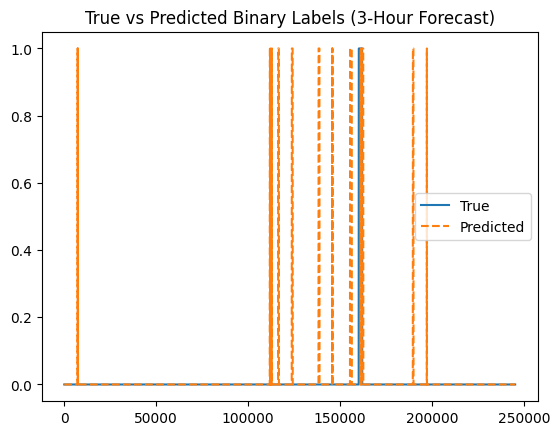

In [6]:
svc = SVC(C=5, kernel='rbf', class_weight='balanced')
svc.fit(X_train_scaled, Y_train)

# Make predictions
Y_pred = svc.predict(X_test_scaled)

print("Classification Report with Best Parameters:")
print(classification_report(Y_test, Y_pred))

plt.plot(Y_test, label="True")
plt.plot(Y_pred, label="Predicted", linestyle='--')
plt.title("True vs Predicted Binary Labels (3-Hour Forecast)")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion matrix of SVM with a 5')

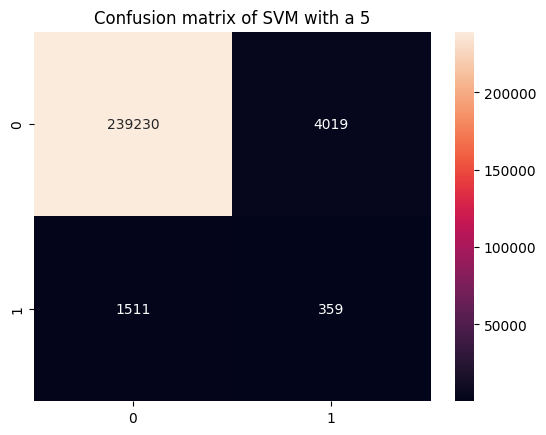

In [7]:
cm_c = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm_c, annot=True, fmt='d').set_title(f"Confusion matrix of SVM with a C value of {svc.C}")

ROC Plot


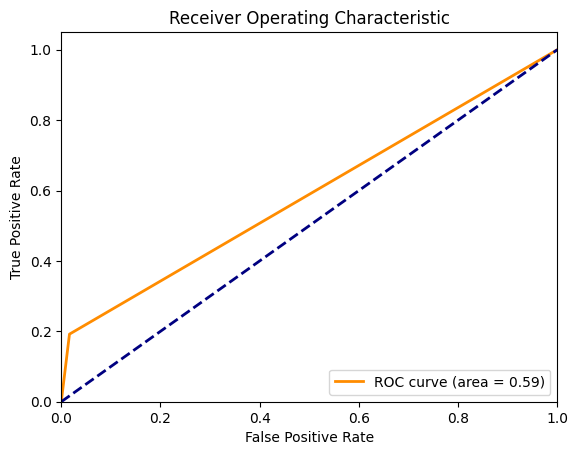

In [8]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Write results to file

In [9]:
# Save the classification report to a file
report = classification_report(Y_test, Y_pred)
with open("/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester_2/Skripsie/Report/images/results/reports/classification_report.txt", "a") as file:
    file.write(f"\nSVC Parameters:\nC: {svc.C}\nKernel: {svc.kernel}\n")
    file.write(f"Classification Report:\n{report}\n")

In [10]:
# df_resampled = eda.calculate_mean_of_five_in_chunks(df,1000, 5)
# df = df_resampled

In [11]:
# # Check if the DataFrame has a time index
# if not isinstance(df.index, pd.DatetimeIndex):
#     # Create a time index based on the sampling rate
#     time_index = pd.date_range(start=0, periods=len(df), freq=f'{1/(1/12)}s')
#     df.index = time_index



# Perform the Fourier transform on each column
# fft_results = {}
# for column in df.columns[0:6]:
#     print(column)
#     ser = df[column].squeeze()
#     print(ser)
#     fft_data = fft(ser)
#     # fft_results[column] = fft_data
# print("GOt to this point!")
# # Create a DataFrame from the Fourier transform results
# fft_df = pd.DataFrame(fft_results)

# # Calculate the frequency axis based on the sampling rate and number of samples
# frequency_axis = np.fft.fftfreq(len(df), 1/(1/12))

# # Add the frequency axis as a new index
# fft_df.index = frequency_axis